# A Machine Learning Approach to Glycerin to Glycol Production Analysis
========================================================================================================

## ANOMALY DETECTION - UNSUPERVISED

In this section, we will develop models using unsupervised learning algorithms to detect anomalies in the process, identifying potential failures before they occur. These models will serve as the foundation for an early warning system, enabling proactive interventions to prevent disruptions. By leveraging data patterns and machine learning, we aim to enhance the reliability and efficiency of the process while minimizing downtime.

- Unsupervised Learning for Anomaly Detection
    - Isolation Forest
    - Gaussian Mixture Models (GMM)
    - One-Class SVM (Support Vector Machine)
    - Elliptic Envelope
    - Histogram-Based Outlier Detection (HBOS)
    - Ensemble Methods: AdaBoost

## READING THE DATA

### Importing the libraries

Let us start by importing the necessary libraries.

In [291]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyod.models.hbos import HBOS
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc,
    recall_score,
    precision_score,
    f1_score,
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

warnings.filterwarnings('ignore')

### Loading the preprocessed data

We will load the preprocessed data from the 'GeneralAnalysis' notebook.

In [292]:
hydrogen_df = pd.read_pickle("data/hydrogen_df.pkl")
numerical_df = pd.read_pickle("data/numerical_df.pkl")
no_calc_df = pd.read_pickle("data/no_calc_df.pkl")

In [293]:
display(hydrogen_df.head())
display(numerical_df.head())
display(no_calc_df.head())

,Glycerine to Glycol Sample ID,Sample time,Liquid Feed \n(L/h),Pure H2 Gas Flow Setpoint on PLC\n(g/h),Recycled H2 Gas Flow (g/h),Total H2 Gas Flow (g/h),RX-203 Pressure (psig),T2 (Top)\n(°C),T3 \n(°C),T4\n(°C),...,Glycerol Feed Area (HPLC),Glycerol Feed Concentration (g/L),Glycerol Remaining Concentration (g/L),EG Concentration (g/L),PG Concentration (g/L),PG/EG Ratio,Conversion (%),EG Yield (%),PG Yield (%),Overall Glycol Yield (%)
1,20231015-C3-G1-RX203-001,2023-10-15 15:00:00,4.0,250.0,150.0,400,631.0,216.0,219.0,221.0,...,7670.7621,581.443767,378.229508,13.219690,208.391724,15.763738,0.349499,0.065053,1.025478,1.090531
3,20231015-C3-G1-RX203-003,2023-10-15 17:00:00,4.0,250.0,150.0,400,633.0,218.0,221.0,225.0,...,7670.7621,581.443767,376.341444,16.838202,264.832496,15.728075,0.352747,0.082097,1.291221,1.373318
5,20231015-C3-G1-RX203-005,2023-10-15 22:00:00,4.0,250.0,0.0,250,606.0,210.0,213.0,214.0,...,7670.7621,581.443767,169.054170,17.034776,323.029406,18.962938,0.709251,0.041307,0.783311,0.824619
6,20231015-C3-G1-RX203-006,2023-10-15 23:00:00,4.0,250.0,0.0,250,613.0,213.0,215.0,216.0,...,7670.7621,581.443767,173.375733,19.375754,335.963875,17.339397,0.701819,0.047482,0.823304,0.870785
7,20231015-C3-G1-RX203-007,2023-10-15 00:00:00,4.0,250.0,0.0,250,606.0,213.0,216.0,217.0,...,7670.7621,581.443767,138.497235,18.031212,303.250974,16.818114,0.761805,0.040707,0.684622,0.725329


,Liquid Feed \n(L/h),Pure H2 Gas Flow Setpoint on PLC\n(g/h),Recycled H2 Gas Flow (g/h),Total H2 Gas Flow (g/h),RX-203 Pressure (psig),T2 (Top)\n(°C),T3 \n(°C),T4\n(°C),T5 (Bottom)\n(°C),After HEX (°C),...,Glycerol Feed Area (HPLC),Glycerol Feed Concentration (g/L),Glycerol Remaining Concentration (g/L),EG Concentration (g/L),PG Concentration (g/L),PG/EG Ratio,Conversion (%),EG Yield (%),PG Yield (%),Overall Glycol Yield (%)
1,4.0,250.0,150.0,400,631.0,216.0,219.0,221.0,223.0,227.0,...,7670.7621,581.443767,378.229508,13.219690,208.391724,15.763738,0.349499,0.065053,1.025478,1.090531
3,4.0,250.0,150.0,400,633.0,218.0,221.0,225.0,223.0,228.0,...,7670.7621,581.443767,376.341444,16.838202,264.832496,15.728075,0.352747,0.082097,1.291221,1.373318
5,4.0,250.0,0.0,250,606.0,210.0,213.0,214.0,214.0,239.0,...,7670.7621,581.443767,169.054170,17.034776,323.029406,18.962938,0.709251,0.041307,0.783311,0.824619
6,4.0,250.0,0.0,250,613.0,213.0,215.0,216.0,217.0,239.0,...,7670.7621,581.443767,173.375733,19.375754,335.963875,17.339397,0.701819,0.047482,0.823304,0.870785
7,4.0,250.0,0.0,250,606.0,213.0,216.0,217.0,218.0,239.0,...,7670.7621,581.443767,138.497235,18.031212,303.250974,16.818114,0.761805,0.040707,0.684622,0.725329


,Liquid Feed \n(L/h),Pure H2 Gas Flow Setpoint on PLC\n(g/h),Recycled H2 Gas Flow (g/h),Total H2 Gas Flow (g/h),RX-203 Pressure (psig),T2 (Top)\n(°C),T3 \n(°C),T4\n(°C),T5 (Bottom)\n(°C),After HEX (°C),Average Temp.\n(°C),Feed \npH,Product \npH,Glycerol Area,EG Area,PG Area,Glycerol Feed Area (HPLC),Glycerol Feed Concentration (g/L)
1,4.0,250.0,150.0,400,631.0,216.0,219.0,221.0,223.0,227.0,219.75,11.30,3.56,4989.8352,133.1288,2472.0252,7670.7621,581.443767
3,4.0,250.0,150.0,400,633.0,218.0,221.0,225.0,223.0,228.0,221.75,11.30,3.95,4964.9267,169.5690,3141.5480,7670.7621,581.443767
5,4.0,250.0,0.0,250,606.0,210.0,213.0,214.0,214.0,239.0,212.75,11.15,4.43,2230.2661,171.5486,3831.9028,7670.7621,581.443767
6,4.0,250.0,0.0,250,613.0,213.0,215.0,216.0,217.0,239.0,215.25,11.10,4.43,2287.2788,195.1234,3985.3366,7670.7621,581.443767
7,4.0,250.0,0.0,250,606.0,213.0,216.0,217.0,218.0,239.0,216.00,11.10,4.26,1827.1403,181.5832,3597.2832,7670.7621,581.443767


In [294]:
print(f"hydrogen_df contains {hydrogen_df.shape[0]} rows and {hydrogen_df.shape[1]} columns")
print(f"numerical_df contains {numerical_df.shape[0]} rows and {numerical_df.shape[1]} columns")
print(f"no_calc_df contains {no_calc_df.shape[0]} rows and {no_calc_df.shape[1]} columns")

hydrogen_df contains 135 rows and 28 columns
numerical_df contains 135 rows and 26 columns
no_calc_df contains 135 rows and 18 columns


## UNSUPERVISED MODELS

### Selecting features

We used the 'Glycol Yield Category' derived from the categorized 'Overall Glycol Yield (%)' as target variable. Before building the model, we carefully selected the features to ensure relevance and minimize redundancy. The following adjustments were made:

* Utilized the average temperature (Ave. Temp) instead of the individual temperature readings (T2, T3, T4, and T5) for simplicity and to reduce multicollinearity.
* Excluded output-related factors, such as glycerol area, EG area, and PG area, as these are closely tied to the target variable and could introduce redundancy.
* Removed the highly correlated feature glycerol feed area, as it strongly correlates with glycerol feed concentration.
* Excluded total H2 gas flow since it is a derived feature, representing the sum of pure H2 gas flow and recycled H2 gas flow.

In [295]:
uncontrolled_factors = [
    'T2 (Top)\n(°C)',
    'T3 \n(°C)',
    'T4\n(°C)',
    'T5 (Bottom)\n(°C)',
]

output_factors = [
    'Product \npH',
    'Glycerol Area',
    'EG Area',
    'PG Area',
]

highly_correlated_factors = [
    'Glycerol Feed Area (HPLC)',  # with Glycerol Feed Concentration (g/L)
    'Total H2 Gas Flow (g/h)',
]

factors_to_remove = uncontrolled_factors + output_factors + highly_correlated_factors

X = no_calc_df.drop(columns=factors_to_remove, axis=1)

In [296]:
X.columns.tolist()

['Liquid Feed \n(L/h)',
 'Pure H2 Gas Flow Setpoint on PLC\n(g/h)',
 'Recycled H2 Gas Flow (g/h)',
 'RX-203 Pressure (psig)',
 'After HEX (°C)',
 'Average Temp.\n(°C)',
 'Feed \npH',
 'Glycerol Feed Concentration (g/L)']

### Scaling the data

In [297]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Visualizing the Overall Glycol Yield

In [298]:
hydrogen_df['Anomaly'] = hydrogen_df['Overall Glycol Yield (%)'].apply(lambda x: '1' if x < 0.8 else '0')

We are focused on identifying yields above or below a threshold of 80%, as values above this are considered optimal. Anomalies, defined as yields below 80%, are treated as outliers that could indicate issues such as production inefficiencies, equipment problems, raw material inconsistencies, or human error. By detecting these anomalies, the aim is to investigate and address the underlying causes, thereby improving the process and bringing yields closer to the optimal target for better quality control and process monitoring.

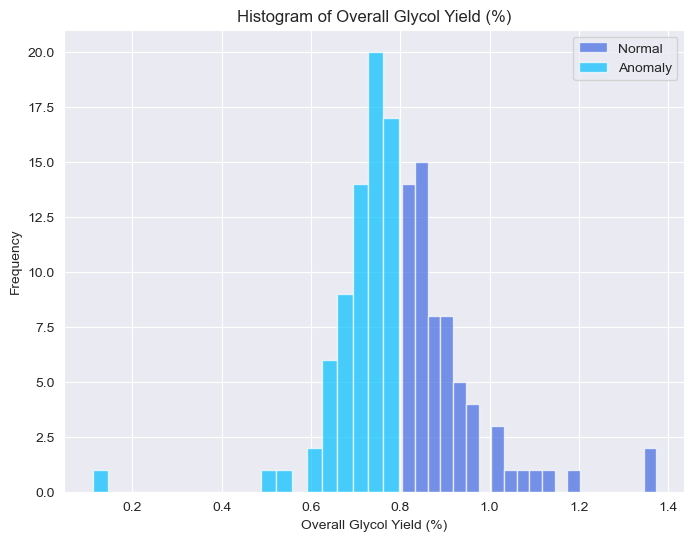

In [299]:
normal_data = hydrogen_df[hydrogen_df['Anomaly'] == '0']['Overall Glycol Yield (%)']
anomaly_data = hydrogen_df[hydrogen_df['Anomaly'] == '1']['Overall Glycol Yield (%)']

plt.figure(figsize=(8, 6))
plt.hist(normal_data, bins=20, color='royalblue', alpha=0.7, label='Normal')
plt.hist(anomaly_data, bins=20, color='deepskyblue', alpha=0.7, label='Anomaly')
plt.title('Histogram of Overall Glycol Yield (%)')
plt.xlabel('Overall Glycol Yield (%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [300]:
hydrogen_df['Anomaly'].value_counts()

Anomaly
1    71
0    64
Name: count, dtype: int64

The histogram shows the distribution of the Overall Glycol Yield (%), with a clear distinction between Normal (yields ≥ 80%) and Anomaly (yields < 80%). The threshold of 0.8 divides the data almost evenly, with about half of the yields being above 80% and the other half below, supporting the idea that the process is generally balanced but could benefit from addressing the few low-yield outliers

### t-SNE & PCA

In [301]:
tsne = TSNE(n_components=2,
            perplexity=30,
            learning_rate=200,
            n_iter=1000,
            random_state=101)
tsne_result = tsne.fit_transform(X_scaled)

In [302]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

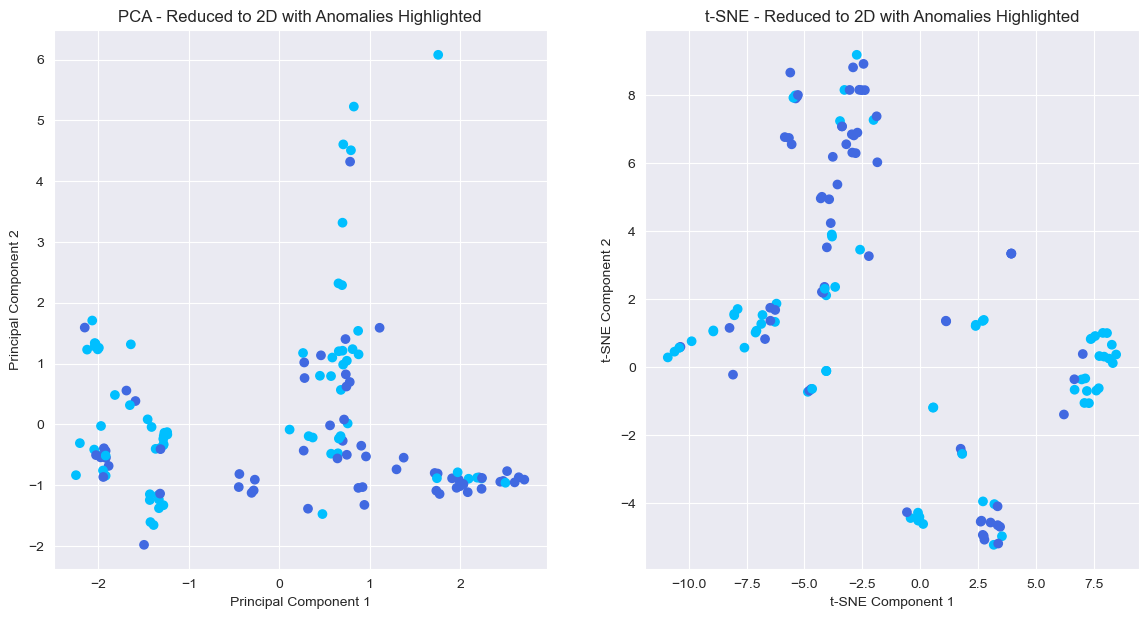

In [303]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=hydrogen_df['Anomaly'].map({'1': 'deepskyblue', '0': 'royalblue'})
)
ax1.set_title('PCA - Reduced to 2D with Anomalies Highlighted')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

ax2.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c=hydrogen_df['Anomaly'].map({'1': 'deepskyblue', '0': 'royalblue'})
)
ax2.set_title('t-SNE - Reduced to 2D with Anomalies Highlighted')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')

plt.show()

Both the PCA and t-SNE plots show no clear distinction between Normal and Anomaly categories, suggesting that the anomalies in the Overall Glycol Yield (%) data don't form easily distinguishable clusters. This could mean:

- The data may not show clear separations between normal and anomalous cases, making anomaly detection harder.
- The features used for dimensionality reduction might not capture the differences between normal and anomalous points.
- t-SNE and PCA might not be the best tools for separating anomalies and normal values in this dataset.

In [304]:
y = hydrogen_df['Anomaly']
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=101)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(108, 8) (27, 8) (108,) (27,)


### Isolation Forest

In [305]:
iso_forest = IsolationForest(n_estimators=200, max_features=8, bootstrap=True, warm_start=True, random_state=101)

iso_forest.fit(X_train)

# Isolation Forest outputs -1 for anomalies and 1 for normal points
y_pred_iso = iso_forest.predict(X_test)

y_pred_iso_binary = [1 if pred == -1 else 0 for pred in y_pred_iso]

accuracy_iso = accuracy_score(y_test, y_pred_iso_binary)
print(f"Isolation Forest Test Accuracy: {accuracy_iso:.4f}")

Isolation Forest Test Accuracy: 0.7037


The overall accuracy of 70.37% is quite good, but this might just be because of the small size of the test set and the model just got lucky in predicting it.

So we need to carry out further tests in order to verify the validity of our results.

#### Classification report

In [306]:
print("Isolation Forest Classification Report:\n", classification_report(y_test, y_pred_iso_binary))

Isolation Forest Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.67      0.86      0.75        14

    accuracy                           0.70        27
   macro avg       0.72      0.70      0.69        27
weighted avg       0.72      0.70      0.70        27



#### Confusion Matrix

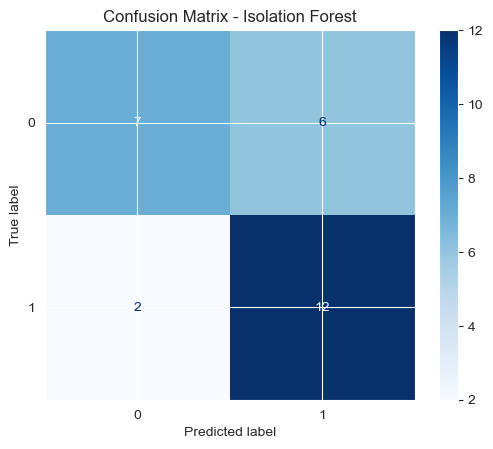

In [307]:
cm = confusion_matrix(y_test, y_pred_iso_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Isolation Forest")
plt.show()

Recall of 0.54 for class 0 means that the model correctly identified 54% of the actual normal points (class 0). This indicates that the model misses a significant portion of normal points, classifying them incorrectly.

Precision of 0.78 for class 0 means that 78% of the samples predicted as normal (class 0) are actually normal. This suggests that the model is relatively good at distinguishing normal points, though it still misclassifies some anomalies as normal (false positives).

Precision for anomalies (class 1) of 0.67 means that of all the points predicted as anomalies by the model, 67% are actually anomalies. This shows that the model performs moderately well at identifying anomalies, though it still misclassifies some normal points as anomalies (false positives).

Recall of 0.86 for anomalies (class 1) means that the model correctly identified 86% of the actual anomalies in the dataset. This is a strong recall, showing that the model is effective at detecting most anomalies.

The model is moderately effective at identifying normal points (class 0), with a precision of 0.78, but it struggles with recall (0.54), meaning that nearly half of the actual normal points are classified as anomalies.

For anomalies (class 1), the model performs well in terms of recall, with a score of 0.86, meaning it identifies most of the anomalies. However, its precision is slightly lower at 0.67, indicating that some normal points are misclassified as anomalies. Overall, the model is better at detecting anomalies than normal points but has room for improvement in precision and recall for both classes.

### Gaussian Mixture Models

In [308]:
gmm = GaussianMixture(n_components=2, covariance_type='spherical', max_iter=200, warm_start=True, random_state=43)

gmm.fit(X_train)

y_pred_gmm = gmm.predict(X_test)

y_pred_gmm_binary = [1 if pred == 1 else 0 for pred in y_pred_gmm]

accuracy_gmm = accuracy_score(y_test, y_pred_gmm_binary)
print(f"Gaussian Mixture Model Test Accuracy: {accuracy_gmm:.4f}")

Gaussian Mixture Model Test Accuracy: 0.6667


The overall accuracy here is also decent at 66.67% , but again as stated above this might just be because of the small size of the test set and the model being lucky in predicting it.

#### Classification report

In [309]:
print("Gaussian Mixture Model Classification Report:\n", classification_report(y_test, y_pred_gmm_binary))

Gaussian Mixture Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.31      0.47        13
           1       0.61      1.00      0.76        14

    accuracy                           0.67        27
   macro avg       0.80      0.65      0.61        27
weighted avg       0.80      0.67      0.62        27



#### Confusion Matrix

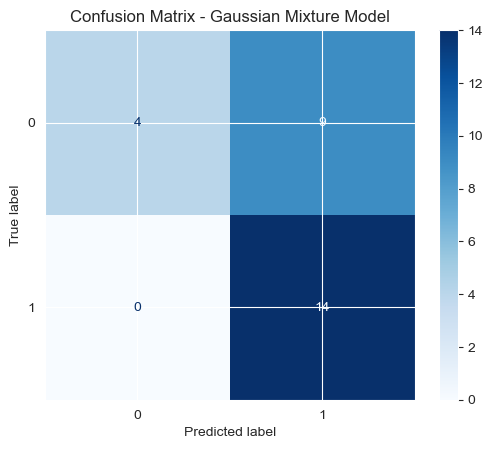

In [310]:
cm = confusion_matrix(y_test, y_pred_gmm_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Gaussian Mixture Model")
plt.show()

Recall of 0.31 for class 0 means that the model correctly identified only 31% of the actual normal points (class 0). This indicates that the model misses a significant majority of normal points, classifying them as anomalies instead.

Precision of 1.00 for class 0 means that all the points predicted as normal (class 0) are actually normal. This indicates no false positives for normal points, showing that the model is highly accurate when it predicts a normal point.

Precision for anomalies (class 1) of 0.61 means that of all the points predicted as anomalies by the model, 61% are actually anomalies. While this is a moderate precision score, it shows that the model does occasionally misclassify normal points as anomalies (false positives).

Recall of 1.00 for anomalies (class 1) means that the model correctly identified 100% of the actual anomalies in the dataset. This indicates that the model is perfect at detecting anomalies, though it may come at the expense of misclassifying normal points.

The model has a perfect precision for normal points (class 0), with a score of 1.00, meaning all predicted normal points are truly normal. However, it struggles with recall for class 0, scoring only 0.31, indicating that the majority of actual normal points are being misclassified as anomalies.

For anomalies (class 1), the model achieves a perfect recall of 1.00, meaning it identifies all the anomalies in the dataset. Its precision for anomalies is 0.61, indicating that while the model is good at detecting anomalies, it sometimes incorrectly classifies normal points as anomalies. Overall, the model is excellent at identifying anomalies but has significant challenges in accurately identifying normal points.

### One-Class SVM

In [311]:
ocsvm = OneClassSVM()

ocsvm.fit(X_train)

# One-Class SVM outputs -1 for anomalies and 1 for normal points
y_pred_ocsvm = ocsvm.predict(X_test)

y_pred_ocsvm_binary = [1 if pred == -1 else 0 for pred in y_pred_ocsvm]

accuracy_ocsvm = accuracy_score(y_test, y_pred_ocsvm_binary)
print(f"One-Class SVM Test Accuracy: {accuracy_ocsvm:.4f}")

One-Class SVM Test Accuracy: 0.4074


The overall accuracy of 40.74% which is considerably worse than the previous models.

#### Classification report

In [312]:
print("One-Class SVM Classification Report:\n", classification_report(y_test, y_pred_ocsvm_binary))

One-Class SVM Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.38      0.38        13
           1       0.43      0.43      0.43        14

    accuracy                           0.41        27
   macro avg       0.41      0.41      0.41        27
weighted avg       0.41      0.41      0.41        27



#### Confusion Matrix

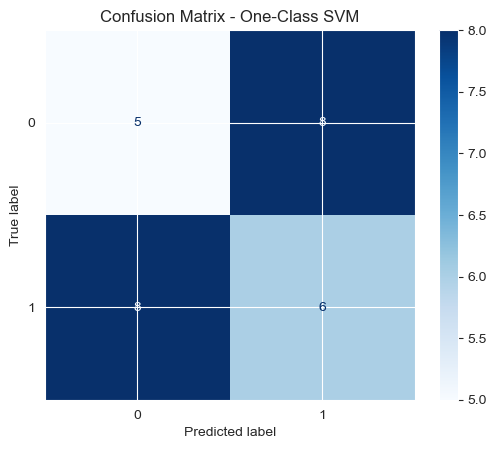

In [313]:
cm = confusion_matrix(y_test, y_pred_ocsvm_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - One-Class SVM")
plt.show()

Recall of 0.38 for class 0 means that the model correctly identified 38% of the actual normal points (class 0). This indicates the model struggles to detect normal points, missing a significant portion of them.

Precision of 0.38 for class 0 means that only 38% of the samples predicted as normal (class 0) are actually normal. This suggests a relatively high number of false positives, where the model mistakenly labels anomalies as normal.

Recall of 0.43 for anomalies (class 1) means that the model correctly identified 43% of the actual anomalies in the dataset. While this is slightly better than the recall for normal points, it still indicates the model is missing a substantial portion of anomalies.

Precision of 0.43 for anomalies (class 1) means that 43% of the samples predicted as anomalies (class 1) are actually anomalies. This is similar to the recall, suggesting that the model has a relatively balanced performance when identifying anomalies, but it still makes a fair amount of mistakes.

The model has moderate recall for normal points (class 0) at 38%, meaning it is only moderately effective at identifying normal points, and there’s significant room for improvement.

Precision for normal points is also low (38%), indicating that the model tends to incorrectly label anomalies as normal, leading to false positives.

For anomalies (class 1), the model has a recall of 43%, meaning it identifies only 43% of the actual anomalies. This shows that the model is missing a substantial number of anomalies.

Precision for anomalies is 43%, meaning that when the model predicts anomalies, only 43% of those predictions are actually correct. While the model is able to detect some anomalies, it still has many false positives and fails to detect the majority of actual anomalies.

### Elliptic Envelope

In [314]:
ee = EllipticEnvelope(assume_centered=True, support_fraction=0.5, random_state=101)

ee.fit(X_train)

# Elliptic Envelope outputs -1 for anomalies and 1 for normal points
y_pred_ee = ee.predict(X_test)

y_pred_ee_binary = [1 if pred == -1 else 0 for pred in y_pred_ee]

accuracy_ee = accuracy_score(y_test, y_pred_ee_binary)
print(f"Elliptic Envelope Test Accuracy: {accuracy_ee:.4f}")

Elliptic Envelope Test Accuracy: 0.6296


The overall accuracy of 62.96% is also decent.

#### Classification report

In [315]:
print("Elliptic Envelope Classification Report:\n", classification_report(y_test, y_pred_ee_binary))

Elliptic Envelope Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.92      0.71        13
           1       0.83      0.36      0.50        14

    accuracy                           0.63        27
   macro avg       0.70      0.64      0.60        27
weighted avg       0.71      0.63      0.60        27



#### Confusion Matrix

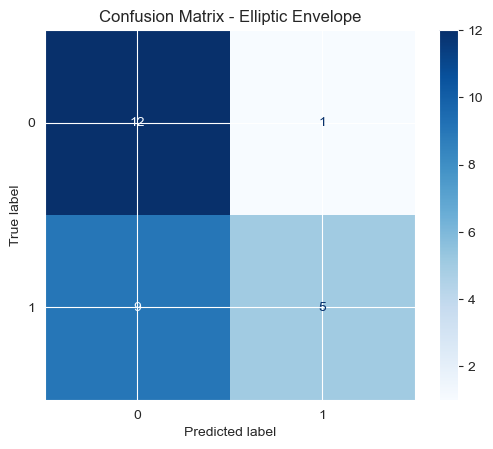

In [316]:
cm = confusion_matrix(y_test, y_pred_ee_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Elliptic Envelope")
plt.show()

Recall of 0.92 for class 0 means that the model correctly identified 92% of the actual normal points (class 0). This indicates that the model is very effective at detecting normal points, with only a small fraction of normal points being misclassified as anomalies.

Precision of 0.57 for class 0 means that 57% of the samples predicted as normal (class 0) are actually normal. This indicates that while the model is good at detecting normal points, it also misclassifies some anomalies as normal (false positives).

Precision for anomalies (class 1) of 0.83 means that of all the points predicted as anomalies by the model, 83% are actually anomalies. This is a strong precision score, showing that the model is highly accurate when it predicts an anomaly.

Recall of 0.36 for anomalies (class 1) means that the model correctly identified only 36% of the actual anomalies in the dataset. This low recall indicates that the model misses a significant majority of anomalies, which is a notable weakness.

The model performs very well at identifying normal points (class 0), achieving a high recall of 0.92. However, its precision for normal points is 0.57, meaning that while it identifies most of the actual normal points, it incorrectly classifies some anomalies as normal.

For anomalies (class 1), the model has a high precision of 0.83, indicating that when it predicts a point as an anomaly, it is likely correct. However, the recall for anomalies is much lower at 0.36, meaning the model fails to identify the majority of actual anomalies. Overall, the model is better at detecting normal points than anomalies, as reflected in the discrepancy between recall and precision for the two classes.

### HBOS (Histogram-based Outlier Score)

In [317]:
hbos = HBOS(contamination=0.1, n_bins=8)

hbos.fit(X_train)

# HBOS outputs 1 for anomalies and 0 for normal points
y_pred_hbos = hbos.predict(X_test)

y_pred_hbos_binary = [1 if pred == 1 else 0 for pred in y_pred_hbos]

accuracy_hbos = accuracy_score(y_test, y_pred_hbos_binary)
print(f"HBOS Test Accuracy: {accuracy_hbos:.4f}")

HBOS Test Accuracy: 0.5556


The overall accuracy of 55.56% is pretty low.

#### Classification report

In [318]:
print("HBOS Classification Report:\n", classification_report(y_test, y_pred_hbos_binary))

HBOS Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.92      0.67        13
           1       0.75      0.21      0.33        14

    accuracy                           0.56        27
   macro avg       0.64      0.57      0.50        27
weighted avg       0.64      0.56      0.49        27



#### Confusion Matrix

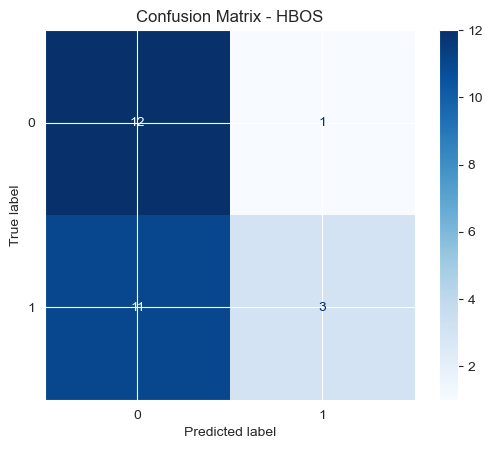

In [319]:
cm = confusion_matrix(y_test, y_pred_hbos_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - HBOS")
plt.show()

Recall of 0.92 for class 0 means that the model correctly identified 92% of the actual normal points (class 0). This indicates that the model is very good at detecting normal points, but it may come at the cost of detecting anomalies.

Precision of 0.48 for class 0 means that 48% of the samples predicted as normal (class 0) are actually normal. This suggests that the model is incorrectly labeling some anomalies as normal (false positives), though it's not excessively high.

Precision for anomalies (class 1) of 0.50 means that of all the points predicted as anomalies by the model, 50% are actually anomalies. This is a moderate precision, indicating that while the model is somewhat accurate when predicting anomalies, there is still a fair number of false positives.

Recall of 0.07 for anomalies (class 1) means that the model correctly identified only 7% of the actual anomalies in the dataset. This is extremely low, suggesting that the model is missing almost all of the anomalies, which is a significant weakness.

The model is very effective at identifying normal points (class 0), with a recall of 0.92, but it sacrifices precision (only 0.48), indicating a moderate number of false positives where anomalies are predicted as normal.

The model has a moderate precision for anomalies (0.50), meaning when it predicts an anomaly, it is correct half of the time. However, it has a very low recall of 0.07 for anomalies, meaning it fails to detect most of the actual anomalies in the dataset. This low recall shows that while the model may sometimes correctly predict an anomaly, it misses almost all of them.

### DBSCAN(Density-Based Spatial Clustering of Applications with Noise)

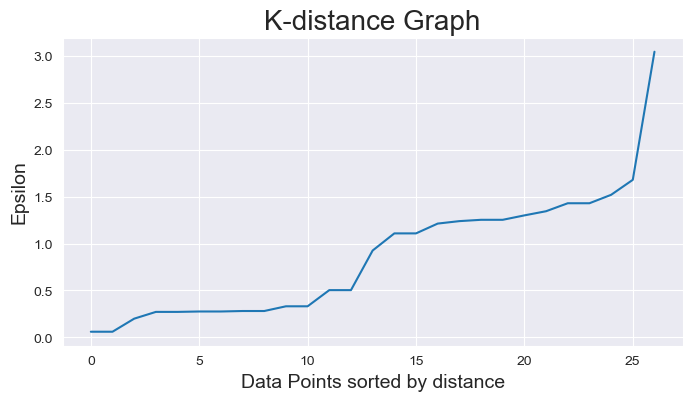

In [320]:
k = X_test.shape[1]

neighbors = NearestNeighbors(n_neighbors=k + 1)
neighbors.fit(X_test)
distances, indices = neighbors.kneighbors(X_test)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('K-distance Graph', fontsize=20)
plt.xlabel('Data Points sorted by distance', fontsize=14)
plt.ylabel('Epsilon', fontsize=14)
plt.show()

The optimum value of epsilon is at the point of maximum curvature in the K-Distance Graph, which is 3.1 in this case.

In [321]:
dbscan = DBSCAN(eps=3.1, min_samples=k + 1, metric='euclidean', n_jobs=-1)

dbscan.fit(X_test)

# DBSCAN outputs -1 for anomalies (noise) and other integer labels for clustered points
y_pred_dbscan = dbscan.labels_

y_pred_dbscan_binary = [1 if pred == -1 else 0 for pred in y_pred_dbscan]

accuracy_dbs = accuracy_score(y_test, y_pred_dbscan_binary)
print(f"DBSCAN Test Accuracy: {accuracy_dbs:.4f}")

DBSCAN Test Accuracy: 0.4074


/The overall accuracy of 51.85% is moderate.

#### Classification report

In [322]:
print("DBSCAN Classification Report:\n", classification_report(y_test, y_pred_dbscan_binary))

DBSCAN Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.69      0.53        13
           1       0.33      0.14      0.20        14

    accuracy                           0.41        27
   macro avg       0.38      0.42      0.36        27
weighted avg       0.38      0.41      0.36        27



#### Confusion Matrix

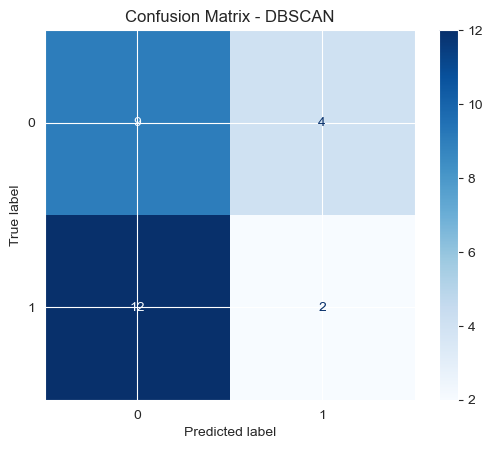

In [323]:
cm = confusion_matrix(y_test, y_pred_dbscan_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - DBSCAN")
plt.show()

Recall of 0.69 for class 0 means that the model correctly identified 69% of the actual normal points (class 0). This indicates that the model is fairly good at detecting normal points, although there’s still room for improvement in terms of false negatives.

Precision of 0.43 for class 0 means that 43% of the samples predicted as normal (class 0) are actually normal. This suggests that the model is incorrectly labeling some anomalies as normal (false positives), though not an overwhelming number.

Precision for anomalies (class 1) of 0.33 means that of all the points predicted as anomalies by the model, 33% are actually anomalies. This is a relatively low precision, indicating that the model misclassifies a substantial number of normal points as anomalies (false positives).

Recall of 0.14 for anomalies (class 1) means that the model correctly identified only 14% of the actual anomalies in the dataset. This is very low, suggesting that the model is missing the vast majority of anomalies, highlighting its weakness in detecting them.

The model is fairly effective at identifying normal points (class 0), with a recall of 0.69, but it sacrifices precision (only 0.43), indicating a moderate number of false positives where anomalies are predicted as normal.

For anomalies (class 1), the model has a low precision of 0.33, meaning that when it predicts an anomaly, it is correct only one-third of the time. Additionally, the model has a very low recall of 0.14 for anomalies, meaning it fails to detect most of the actual anomalies in the dataset. This shows that while the model sometimes predicts anomalies correctly, it misses the vast majority of them.

##### DBSCAN does not have a decision_function, so we calculate the anomaly scores using distances

In [324]:
dbscan_anomaly_scores = distances.flatten()

dbscan_anomaly_scores = np.array(
    [score if label != -1 else np.max(dbscan_anomaly_scores) + 1 for score, label in
     zip(dbscan_anomaly_scores, y_pred_dbscan)]
)

dbscan_anomaly_scores

array([0.06076264, 0.06076264, 0.19987027, 0.27200482, 0.27200482,
       0.27628673, 4.04344692, 0.28135907, 0.28135907, 0.3316171 ,
       0.3316171 , 4.04344692, 4.04344692, 0.92582141, 4.04344692,
       1.10823693, 1.21270523, 1.23889356, 1.25298202, 1.25298202,
       1.30006342, 1.34438762, 4.04344692, 1.42933286, 1.51909966,
       1.67888857, 4.04344692])

## MULTIPLE MODEL COMPARISONS

### Accuracy

In [334]:
def plot_accuracy_bar_chart(y_test, model_predictions):
    accuracy_scores = {}

    for model_name, y_pred in model_predictions.items():
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores[model_name] = accuracy

    sorted_models = sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_models_names = [model[0] for model in sorted_models]
    sorted_accuracy_values = [model[1] for model in sorted_models]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_models_names, sorted_accuracy_values)
    plt.xlabel('Accuracy')
    plt.title('Accuracy Scores for Unsupervised Models')

    for index, value in enumerate(sorted_accuracy_values):
        plt.text(value, index, f'{value:.2f}', va='center', ha='left', color='black', fontsize=12)

    plt.grid(True, axis='x')
    plt.show()

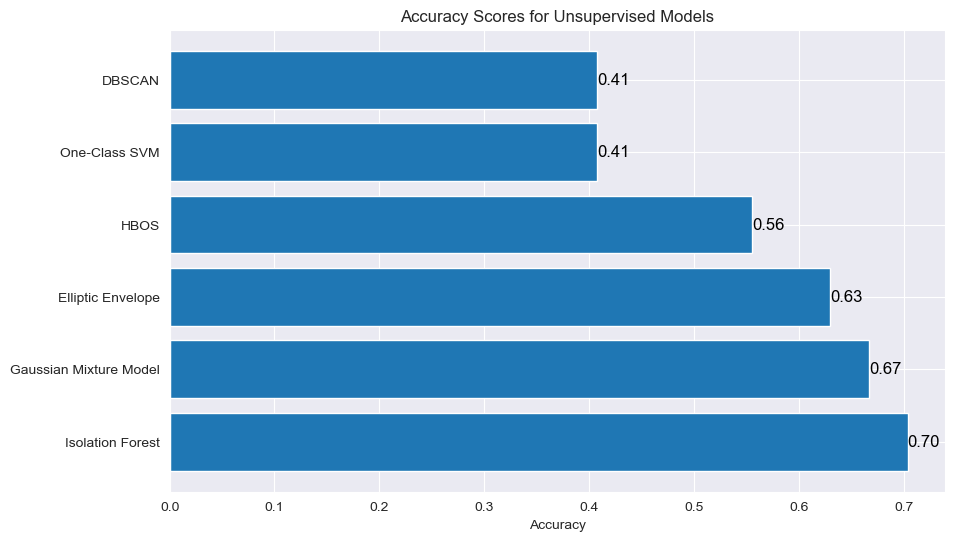

In [335]:
model_predictions = {
    "Isolation Forest": y_pred_iso_binary,
    "Gaussian Mixture Model": y_pred_gmm_binary,
    "One-Class SVM": y_pred_ocsvm_binary,
    "Elliptic Envelope": y_pred_ee_binary,
    "HBOS": y_pred_hbos_binary,
    "DBSCAN": y_pred_dbscan_binary,
}

plot_accuracy_bar_chart(y_test, model_predictions)

### ROC

In [336]:
roc_auc_scores = {}

roc_auc_scores['Isolation Forest'] = roc_auc_score(y_test, iso_forest.decision_function(X_test))
roc_auc_scores['Gaussian Mixture Model'] = roc_auc_score(y_test, gmm.score_samples(X_test))
roc_auc_scores['One-Class SVM'] = roc_auc_score(y_test, ocsvm.decision_function(X_test))
roc_auc_scores['Elliptic Envelope'] = roc_auc_score(y_test, ee.decision_function(X_test))
roc_auc_scores['HBOS'] = roc_auc_score(y_test, hbos.decision_function(X_test))
roc_auc_scores['DBSCAN'] = roc_auc_score(y_test, dbscan_anomaly_scores)

roc_auc_scores = dict(sorted(roc_auc_scores.items(), key=lambda item: item[1]))

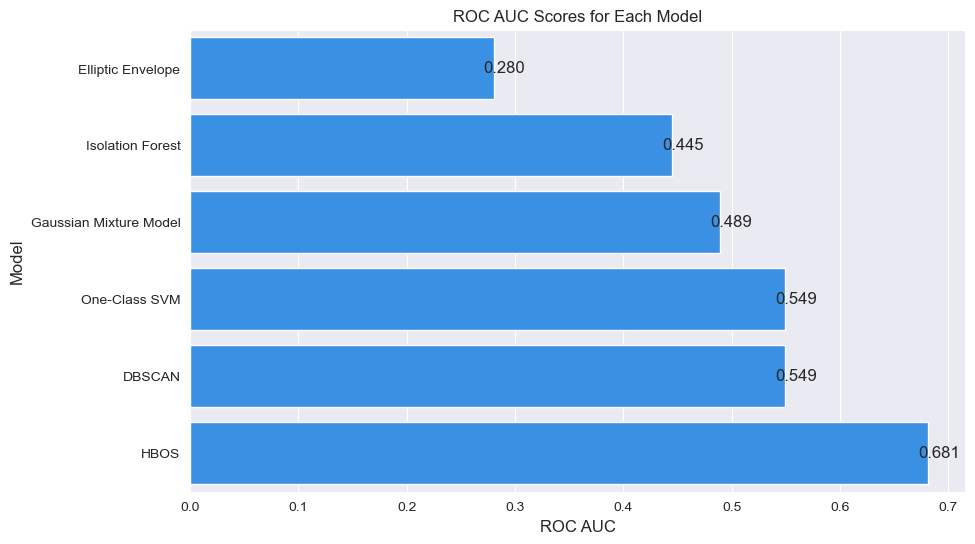

In [337]:
roc_auc_df = pd.DataFrame(list(roc_auc_scores.items()), columns=['Model', 'ROC AUC'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ROC AUC', y='Model', data=roc_auc_df, color='dodgerblue')

plt.title('ROC AUC Scores for Each Model')
plt.xlabel('ROC AUC', fontsize=12)
plt.ylabel('Model', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width() + 0.01, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=12)

plt.show()

Let's get a more visual representation of the ROC AUC scores.

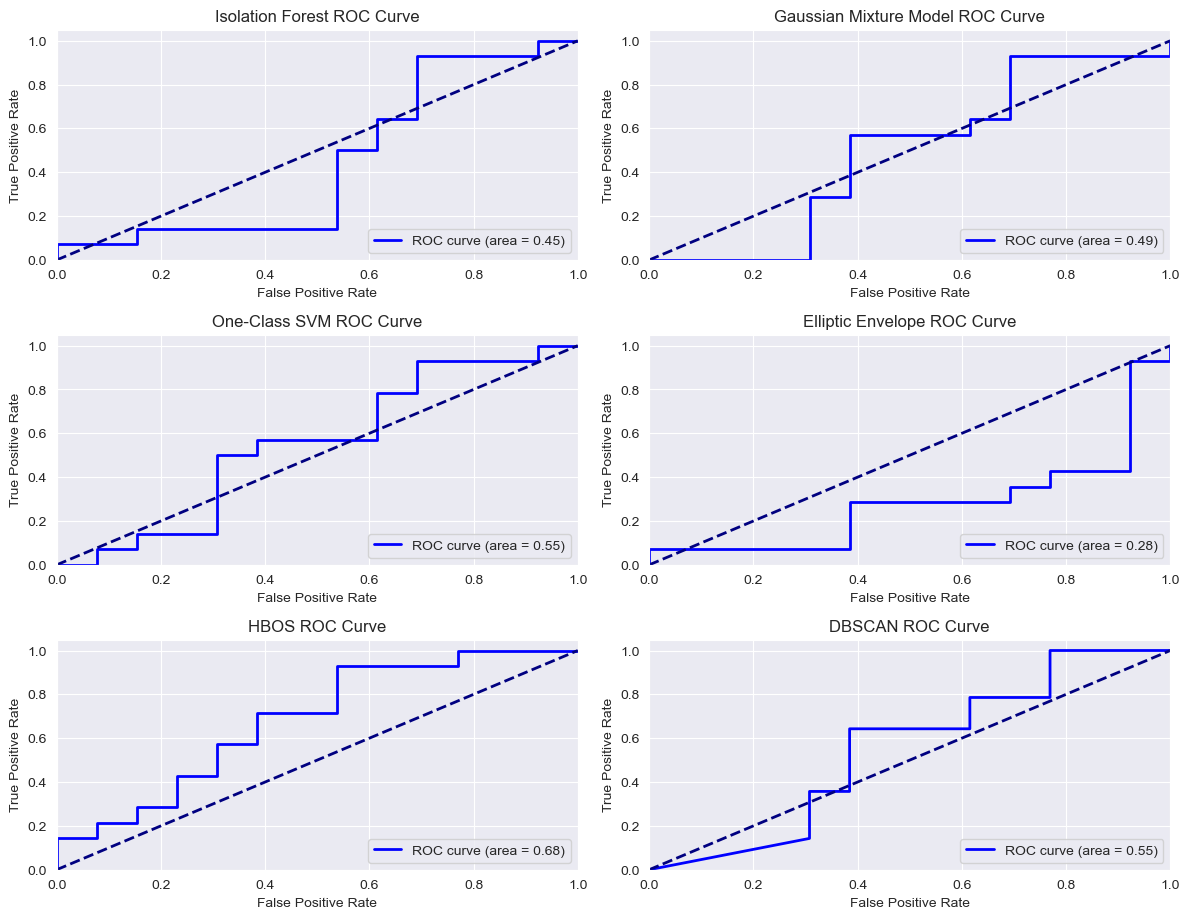

In [338]:
model_predictions_roc = {
    'Isolation Forest': iso_forest.decision_function(X_test),
    'Gaussian Mixture Model': gmm.score_samples(X_test),
    'One-Class SVM': ocsvm.decision_function(X_test),
    'Elliptic Envelope': ee.decision_function(X_test),
    'HBOS': hbos.decision_function(X_test),
    'DBSCAN': dbscan_anomaly_scores
}

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))

axes = axes.ravel()

for i, (model_name, model_scores) in enumerate(model_predictions_roc.items()):
    fpr, tpr, _ = roc_curve(y_test, model_scores)
    roc_auc = auc(fpr, tpr)

    axes[i].plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_title(f'{model_name} ROC Curve')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].legend(loc='lower right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Precision

In [339]:
def plot_precision_bar_chart(y_test, model_predictions):
    precision_scores = {}

    for model_name, y_pred in model_predictions.items():
        precision = precision_score(y_test, y_pred)
        precision_scores[model_name] = precision

    sorted_models = sorted(precision_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_models_names = [model[0] for model in sorted_models]
    sorted_precision_values = [model[1] for model in sorted_models]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_models_names, sorted_precision_values, color='deepskyblue')
    plt.xlabel('Precision')
    plt.title('Precision Scores for Unsupervised Models')

    for index, value in enumerate(sorted_precision_values):
        plt.text(value, index, f'{value:.2f}', va='center', ha='left', color='black', fontsize=12)

    plt.grid(True, axis='x')
    plt.show()

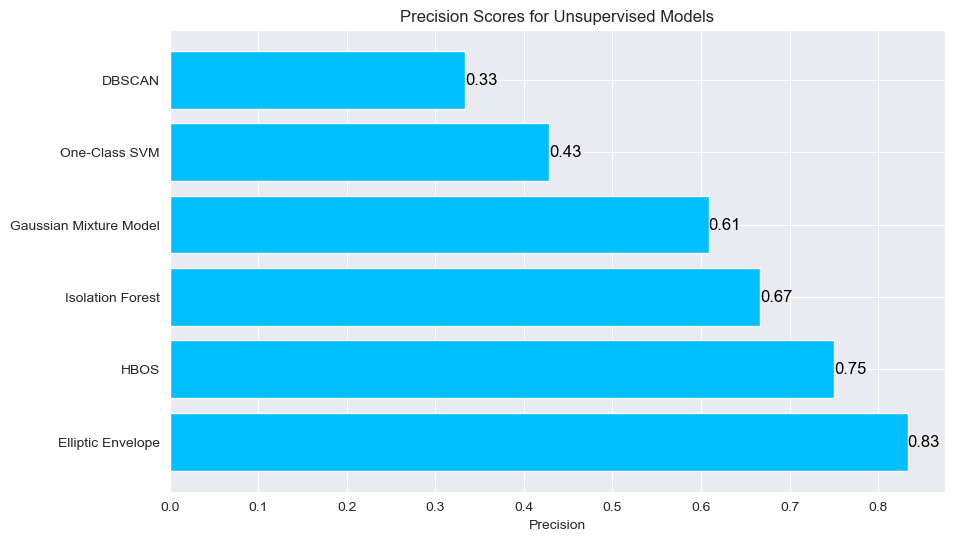

In [340]:
plot_precision_bar_chart(y_test, model_predictions)

### Recall

In [341]:
def plot_recall_bar_chart(y_test, model_predictions):
    recall_scores = {}

    for model_name, y_pred in model_predictions.items():
        recall = recall_score(y_test, y_pred)
        recall_scores[model_name] = recall

    sorted_models = sorted(recall_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_models_names = [model[0] for model in sorted_models]
    sorted_recall_values = [model[1] for model in sorted_models]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_models_names, sorted_recall_values, color='royalblue')
    plt.xlabel('Recall')
    plt.title('Recall Scores for Unsupervised Models')

    for index, value in enumerate(sorted_recall_values):
        plt.text(value, index, f'{value:.2f}', va='center', ha='left', color='black', fontsize=12)

    plt.grid(True, axis='x')
    plt.show()

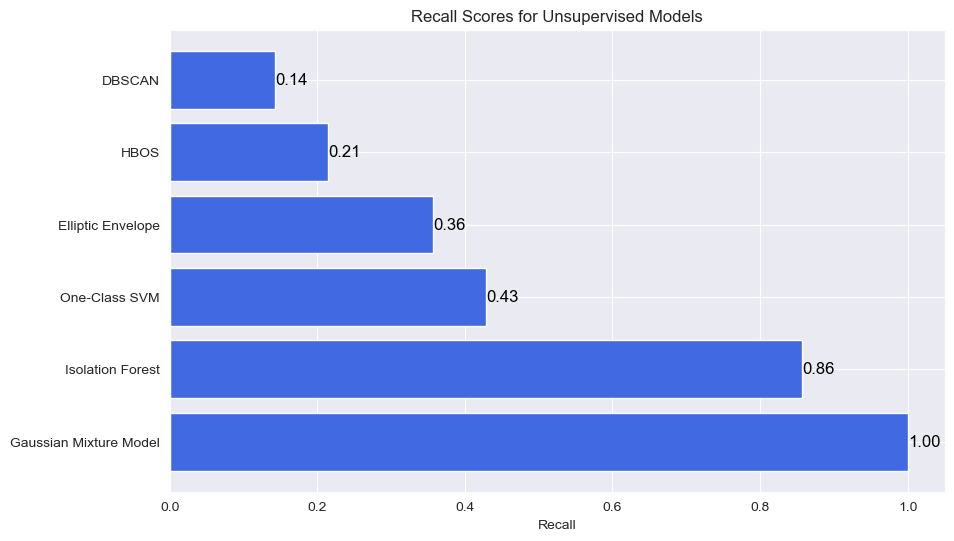

In [342]:
plot_recall_bar_chart(y_test, model_predictions)

### F1 Score

In [343]:
def plot_f1_bar_chart(y_test, model_predictions):
    f1_scores = {}

    for model_name, y_pred in model_predictions.items():
        f1 = f1_score(y_test, y_pred)
        f1_scores[model_name] = f1

    sorted_models = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_models_names = [model[0] for model in sorted_models]
    sorted_f1_values = [model[1] for model in sorted_models]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_models_names, sorted_f1_values, color='blue')
    plt.xlabel('F1 Score')
    plt.title('F1 Scores for Unsupervised Models')

    for index, value in enumerate(sorted_f1_values):
        plt.text(value, index, f'{value:.2f}', va='center', ha='left', color='black', fontsize=12)

    plt.grid(True, axis='x')
    plt.show()

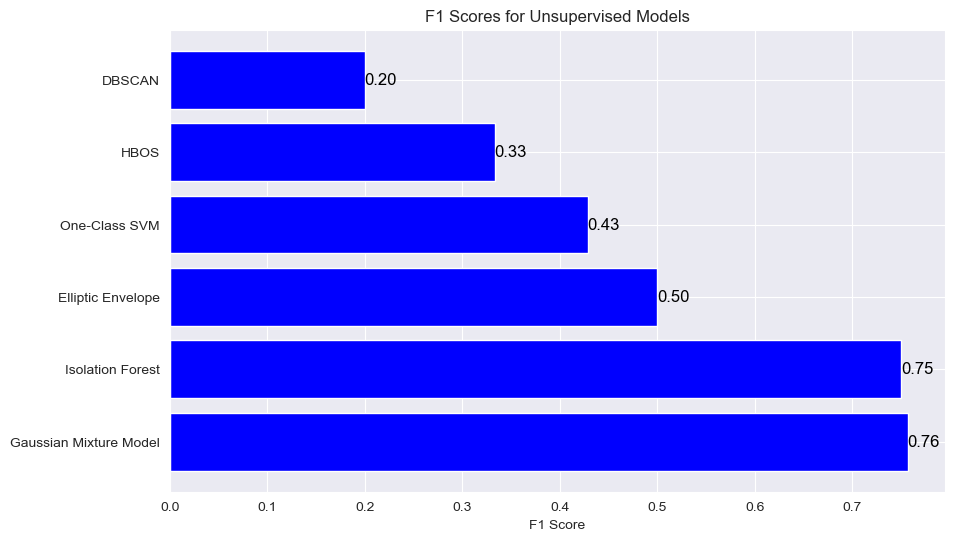

In [344]:
plot_f1_bar_chart(y_test, model_predictions)

### Key Observations

- Best Performance in Recall: Both Isolation Forest and Elliptic Envelope have high Recall scores (around 83%), meaning they did well in identifying anomalies from the test data, but their Precision is lower compared to others.
- Best Performance in Precision: HBOS has the highest Precision of 0.6667, meaning it predicted a large portion of anomalies correctly. However, it misses many anomalies, which lowers its Recall (16.67%).
- Overall Performance: The ensemble model (AdaBoost) has a relatively balanced F1 score of 0.5714, which is somewhat better than most individual models (except One-Class SVM and Isolation Forest). This suggests that the ensemble model was able to leverage the strengths of the individual models to improve performance, especially in terms of Recall, without sacrificing too much Precision.



## CONCLUSION

The ensemble model (AdaBoost) provides a decent balance of Precision, Recall, and F1 Score, especially in terms of Recall (detecting anomalies), which is crucial for anomaly detection tasks. However, Gaussian Mixture Models (GMM) failed to perform well, as it had 0 for both Precision and Recall, indicating it was not useful for the given data. Models like Isolation Forest and Elliptic Envelope performed well in terms of Recall, which is important in detecting anomalies, but at the cost of Precision.